In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
from abbreivations import replacement_dict

# Download NLTK resources
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\chish\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chish\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
df = pd.read_csv('labeled_data.csv')

df.shape

(24783, 7)

In [12]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB



# Removing usernames

In [13]:
# Function to remove usernames
def remove_usernames(tweet):
    return re.sub(r'@\w+', '', tweet)

# Apply the function to the DataFrame
df['tweet'] = df['tweet'].apply(remove_usernames)
df.head()


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT : As a woman you shouldn't complain abo...
1,1,3,0,3,0,1,!!!!! RT : boy dats cold...tyga dwn bad for cu...
2,2,3,0,3,0,1,!!!!!!! RT Dawg!!!! RT : You ever fuck a bitc...
3,3,3,0,2,1,1,!!!!!!!!! RT : she look like a tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT : The shit you hear about me ...


# Removing special symbols

In [14]:
# Function to remove sequence
def remove_sequence(tweet):
    return re.sub(r'\b\d+\b', '', tweet)

# Apply the function to the DataFrame
df['tweet'] = df['tweet'].apply(remove_sequence)
df.head()


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT : As a woman you shouldn't complain abo...
1,1,3,0,3,0,1,!!!!! RT : boy dats cold...tyga dwn bad for cu...
2,2,3,0,3,0,1,!!!!!!! RT Dawg!!!! RT : You ever fuck a bitc...
3,3,3,0,2,1,1,!!!!!!!!! RT : she look like a tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT : The shit you hear about me ...


# Removing Urls

In [15]:
# function to remove urls
def remove_urls(tweet):
    return re.sub(r'http\S+|www\S+|https\S+|@\w+|#\w+', '', tweet, flags=re.MULTILINE)
df['tweet']= df['tweet'].apply(remove_urls) 

# Removing punctuations

In [16]:
df['tweet'] = df['tweet'].str.lower()
 
# Removing punctuations present in the text
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)
 
df['tweet']= df['tweet'].apply(lambda x: remove_punctuations(x))
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,rt as a woman you shouldnt complain about cl...
1,1,3,0,3,0,1,rt boy dats coldtyga dwn bad for cuffin dat ...
2,2,3,0,3,0,1,rt dawg rt you ever fuck a bitch and she st...
3,3,3,0,2,1,1,rt she look like a tranny
4,4,6,0,6,0,1,rt the shit you hear about me might be true ...


# Removing abbreviations

In [17]:

def replace_words(tweet, abbreviations_dict):
    # Create a regex pattern from the keys of the dictionary
    pattern = re.compile(r'\b(' + '|'.join(re.escape(key) for key in abbreviations_dict.keys()) + r')\b')
    # Replace matched words with their corresponding values
    return pattern.sub(lambda x: abbreviations_dict[x.group()], tweet)

# Apply the function to your DataFrame
df['tweet'] = df['tweet'].apply(lambda x: replace_words(x.lower(), replacement_dict))
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,retweet as euro a euro woman euro you euro s...
1,1,3,0,3,0,1,retweet boy euro that is euro coldtyga euro ...
2,2,3,0,3,0,1,retweet friend euro retweet you euro ever e...
3,3,3,0,2,1,1,retweet she euro look euro like euro a euro...
4,4,6,0,6,0,1,retweet the euro shit euro you euro hear eur...


# Lemmatization

In [18]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    imp_words = []
 
    # Storing the important words
    for word in str(text).split():
 
        if word not in stop_words:
 
        # Let's Lemmatize the word as well
        # before appending to the imp_words list.
 
            lemmatizer = WordNetLemmatizer()
            lemmatizer.lemmatize(word)
 
            imp_words.append(word)
 
    output = " ".join(imp_words)
 
    return output
 
 
df['tweet'] = df['tweet'].apply(lambda text: remove_stopwords(text))
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,retweet euro euro woman euro euro shouldnt eur...
1,1,3,0,3,0,1,retweet boy euro euro coldtyga euro euro bad e...
2,2,3,0,3,0,1,retweet friend euro retweet euro ever euro fuc...
3,3,3,0,2,1,1,retweet euro look euro like euro euro tranny
4,4,6,0,6,0,1,retweet euro shit euro euro hear euro euro eur...


In [19]:
df.to_csv('final.csv', index=False) #save as file

# Data visualization

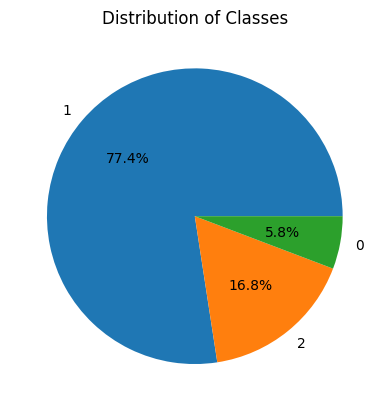

In [20]:
# Data visualization
plt.pie(df['class'].value_counts().values,
        labels=df['class'].value_counts().index,
        autopct='%1.1f%%')
plt.title('Distribution of Classes')
plt.show()

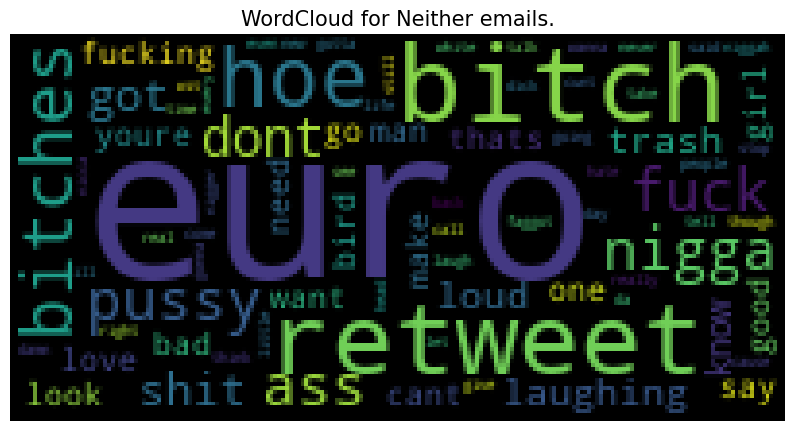

In [21]:
from wordcloud import WordCloud
def plot_word_cloud(data, typ):
# Joining all the tweets to get the corpus
    email_corpus = " ".join(df['tweet'])

    plt.figure(figsize = (10,10))

    # Forming the word cloud
    wc = WordCloud(max_words = 100,
                    width = 200,
                    height = 100,
                    collocations = False).generate(email_corpus)

    # Plotting the wordcloud obtained above
    plt.title(f'WordCloud for {typ} emails.', fontsize = 15)
    plt.axis('off')
    plt.imshow(wc)
    plt.show()
    print()

plot_word_cloud(df[df['class']==2], typ='Neither')


# Loading the dataset and tokenization

Shape of X_train_pad: (15860, 100)
Shape of y_train_cat: (15860, 2)
Shape of X_val_pad: (3966, 100)
Shape of y_val_cat: (3966, 2)
Shape of X_test_pad: (4957, 100)
Shape of y_test_cat: (4957, 2)


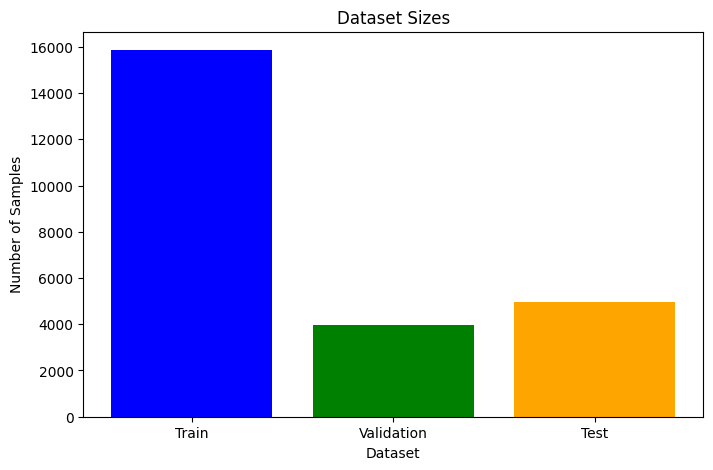

In [23]:
# Tokenization and TF-IDF Vectorization
text_column = 'tweet'

X = df[text_column].values
y = df['class'].values

# Map class 2 to 1 for binary classification (hate speech vs non-hate speech)
label_mapping = {0: 0, 1: 1, 2: 1}
y = np.array([label_mapping[label] for label in y])

# Splitting the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Tokenization
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding sequences
max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Balancing with SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_pad, y_train)

# Convert labels to categorical (one-hot encoding)
y_train_cat = to_categorical(y_train_balanced, num_classes=2)
y_val_cat = to_categorical(y_val, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)


# Model building and plotting


Epoch 1/20


C:\Users\chish\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


496/496 ━━━━━━━━━━━━━━━━━━━━ 40s 72ms/step - accuracy: 0.9392 - loss: 0.9750 - val_accuracy: 0.9415 - val_loss: 0.2242
Epoch 2/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 40s 81ms/step - accuracy: 0.9442 - loss: 0.2078 - val_accuracy: 0.9399 - val_loss: 0.2096
Epoch 3/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 47s 94ms/step - accuracy: 0.9440 - loss: 0.1800 - val_accuracy: 0.9421 - val_loss: 0.1985
Epoch 4/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 48s 97ms/step - accuracy: 0.9498 - loss: 0.1561 - val_accuracy: 0.9385 - val_loss: 0.1950
Epoch 5/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 51s 102ms/step - accuracy: 0.9549 - loss: 0.1447 - val_accuracy: 0.9417 - val_loss: 0.2052
Epoch 6/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 52s 104ms/step - accuracy: 0.9549 - loss: 0.1306 - val_accuracy: 0.9413 - val_loss: 0.2064
Epoch 7/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 51s 103ms/step - accuracy: 0.9607 - loss: 0.1223 - val_accuracy: 0.9330 - val_loss: 0.2053
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step
Weighted F1 Score: 0.9239822701671365
Classification Rep

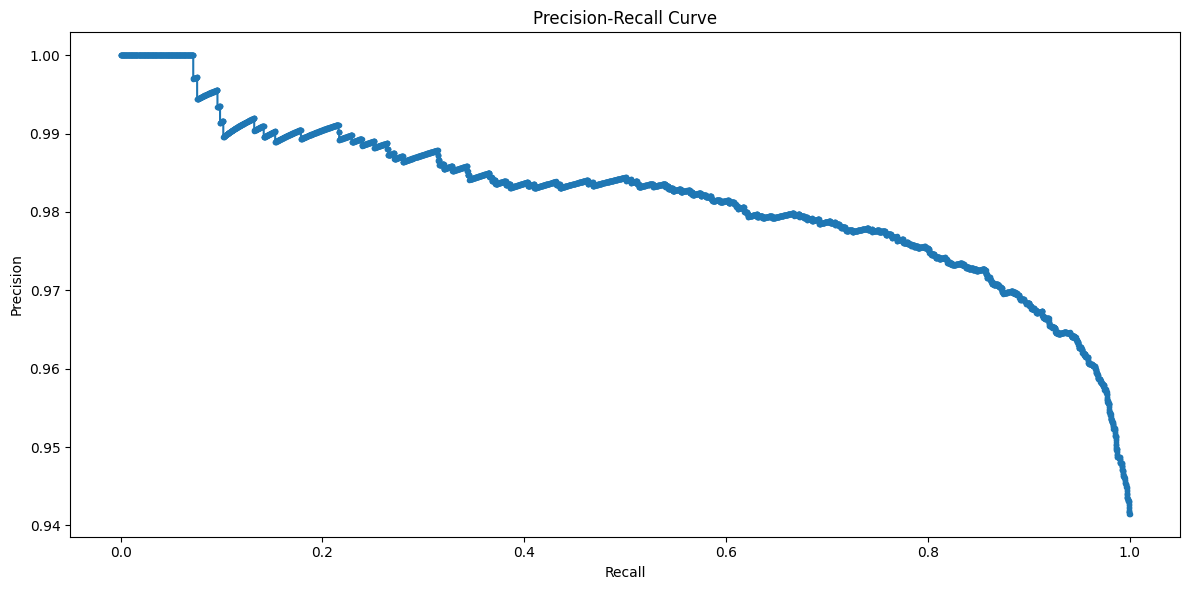

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_8             │ (None, 100, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 128)            │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,254,216 (12.41 MB)

 Trainable params: 1,084,738 (4.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,169,478 (8.28 MB)

In [28]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=100, input_length=max_len))
model.add(SpatialDropout1D(0.3))  # Increased dropout rate
model.add(Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=l2(0.01))))  # Added L2 regularization
model.add(Dense(2, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Implement EarlyStopping with patience
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train_pad, y_train_cat, validation_data=(X_test_pad, y_test_cat),
                    epochs=20, batch_size=32, callbacks=[early_stopping])

# Evaluate the model
y_pred_cat = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_cat, axis=1)

# Calculate F1 score
f1score = f1_score(np.argmax(y_test_cat, axis=1), y_pred, average='weighted')
print("Weighted F1 Score:", f1score)

# Print classification report
print("Classification Report:\n", classification_report(np.argmax(y_test_cat, axis=1), y_pred))

# Plot training history
plt.figure(figsize=(12, 6))

# Plot precision and recall
precision, recall, _ = precision_recall_curve(np.argmax(y_test_cat, axis=1), y_pred_cat[:, 1])
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

# Print model summary
model.summary()

# Save the model and make the predictions 

In [48]:
import pickle
import joblib
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import tensorflow.keras.preprocessing.sequence as tf_seq

# Save the model and tokenizer
model.save('best_model.keras')  # Save the trained model
with open('tokenizer.joblib', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)  # Save the tokenizer

# Example of using the saved model for predictions on new data
# Load the saved model and tokenizer
loaded_model = load_model('best_model.keras')  # Load the saved model
with open('tokenizer.joblib', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)  # Load the saved tokenizer

# Example of predictions on new data (replace with your own uncleaned dataset)
new_data = pd.read_csv('labeled_data.csv')  # Load new data
text_column = 'tweet'  # Column containing text data

new_texts = new_data[text_column].astype(str).fillna('')  # Clean and preprocess text

new_seq = loaded_tokenizer.texts_to_sequences(new_texts)  # Tokenize text
max_len = 100  # Ensure this matches the padding used during training
new_pad = tf_seq.pad_sequences(new_seq, maxlen=max_len)  # Pad sequences

predictions = loaded_model.predict(new_pad)  # Make predictions
predicted_labels = np.argmax(predictions, axis=1)  # Determine predicted labels

# Map labels back to original categories if needed
label_mapping_inverse = {1: 'non_hate_speech', 0: 'hate_speech'}
predicted_labels_names = [label_mapping_inverse[label] for label in predicted_labels]

# Add predictions to the dataframe
new_data['predicted_label'] = predicted_labels_names  # Add predicted labels to DataFrame
new_data.to_csv('predictions.csv', index=False)  # Save predictions to CSV

# Print model summary
loaded_model.summary()  # Display a summary of the loaded model


775/775 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_8             │ (None, 100, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 128)            │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,254,216 (12.41 MB)

 Trainable params: 1,084,738 (4.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,169,478 (8.28 MB)